In [1]:
import os

import numpy as np
import tensorflow as tf

from dataloader import MRIDataLoader

2023-04-30 14:43:26.038515: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 14:43:28.097883: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def get_gradients(model, img_input, top_pred_idx):
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, images)
    return grads


def get_integrated_gradients(model, img_input, top_pred_idx, baseline=None, num_steps=50):
    if baseline is None:
        baseline = np.zeros_like(img_input).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(model, img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads

In [3]:
data_path = "/home/dit905/bmi707/bmi707_alzheimers_mri_prediction/data"

loader = MRIDataLoader(
    data_path=os.path.join(data_path, "preprocessed"),
    metadata_path=os.path.join(data_path, "metadata.csv"),
    shuffle_all=False, shuffle_batch=False, 
    batch_size=256, verbose=False, augment_data=False)

In [4]:
model_path = "/home/dit905/bmi707/bmi707_alzheimers_mri_prediction/results/pretrainedfinal_noaug/saved_model"

model = tf.keras.models.load_model(model_path)

2023-04-30 14:43:38.522332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10766 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:89:00.0, compute capability: 3.7


(128, 128)


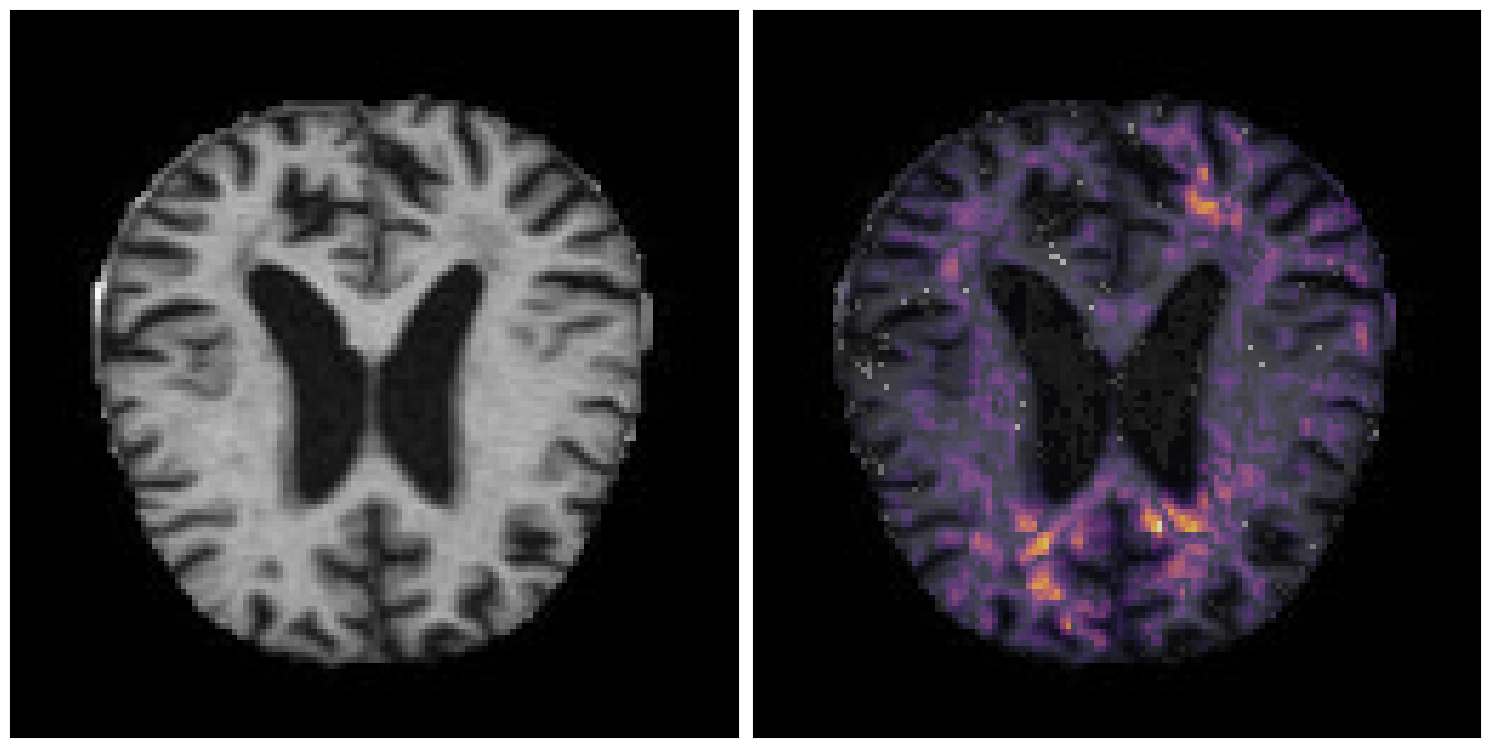

In [10]:
from matplotlib import pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


data, label = loader.__getitem__(1)
igrads = tf.reduce_sum(np.abs(get_integrated_gradients(model, data[0], tf.argmax(label[0]))), axis=-1)
igrads = (igrads - np.min(igrads)) / (np.max(igrads) - np.min(igrads))
igrads = np.ma.masked_where(np.abs(igrads) < 0.01, igrads)
print(igrads.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(data[0].astype(np.int32), cmap="binary_r")
ax[1].imshow(data[0].astype(np.int32), cmap="binary_r")
ax[1].imshow(np.abs(igrads), cmap="inferno", alpha=0.6)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.tight_layout()
plt.savefig("igrads.png", dpi=1000)
plt.show()